In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D


%matplotlib notebook

In [41]:
def find_best_path(start, end, num_obstacles = 10):
    '''
    Find the optimal path and time for the free time horizon problem.
    Plot the solution and return the optimal time.
    '''
    all_obstacles = []
    if isinstance(num_obstacles, int):
        obstacles = np.random.uniform(start,end,(num_obstacles,2))
    #print(obstacles)

    all_obstacles.append(obstacles)
    
    def update_obstacles(obs_x,obs_y,dx,dy):
        rand_x = np.random.uniform(-.1,.1,10).reshape(-1,1)
        rand_y = np.random.uniform(-.1,.1,10).reshape(-1,1)
        return np.hstack((obs_x+rand_x,obs_y+rand_y))
        
    k_a, k_c = 0.1,0.5

    def hamiltonian(Y):
        x,y,vx,vy,p1,p2,p3,p4 = Y
        denominators = np.sum((all_obstacles[-1]-Y[:2])**2, axis = 1)**2
        return p1*vx + p2*vy + p3**2/(4*k_a) + p4**2/(4*k_a)\
                - 1 - k_c*np.sum(1/denominators)

    def ode(t,Y,t_f):
        ''' define the ode system '''
        #print(Y)
        px,py,vx,vy,p1,p2,p3,p4 = Y

        dx = vx
        dy = vy
        dvx = p3/(2*k_a)
        dvy = p4/(2*k_a)

        denominators = np.sum((all_obstacles[-1][:,:,np.newaxis]-Y[:2])**2, axis = 1)**2
        dp1 = 2*k_c*np.sum((all_obstacles[-1][:,0,np.newaxis]-Y[0])/denominators, axis = 0)
        dp2 = 2*k_c*np.sum((all_obstacles[-1][:,1,np.newaxis]-Y[1])/denominators, axis = 0)
        dp3 = -p1
        dp4 = -p2
        new_obstacle = update_obstacles(all_obstacles[-1][:,0].reshape(-1,1),all_obstacles[-1][:,1].reshape(-1,1),dx,dy)
        all_obstacles.append(new_obstacle)
        return t_f[0]*np.array([dx,dy,dvx,dvy,dp1,dp2,dp3,dp4])
    
    def bc(ya,yb,t_f):
        ''' define the boundary conditions '''
        # ya are the initial values
        # yb are the final values
        # each entry of the return array will be set to zero
        left = np.array([ya[0]-start[0],ya[1]-start[1],ya[2],ya[3]])
        right = np.array([yb[0]-end[0],yb[1]-end[1],yb[2],yb[3]])
        h_tf = np.array([hamiltonian(yb)])
        return np.concatenate((left, right, h_tf))
    
    # give the time domain
    t_steps = 100
    t = np.linspace(0,1,t_steps)
    
    # give an initial guess
    y0 = np.zeros((8,t_steps))

    #start with an initial straight path
    #TODO: fix to make work with different start and end conditions
    y0[0], y0[1] = t, t
    y0[2:4] = 1

    t_f = np.array([1])
    
    # solve the system
    sol = solve_bvp(ode, bc, t, y0, t_f, max_nodes = 30000)
    return sol,all_obstacles

sol,all_obstacles = find_best_path((0,0),(1,1))

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((-2.5,2.5))
ax.set_xlim((-2.5,2.5))

animation.writer = animation.writers['ffmpeg']
plt.ioff()

particle, = plt.plot([],[],color='r')
obs1, = plt.plot([],[],'bo',ms=6)

#update function for the animation
t0 = np.linspace(0,1,len(all_obstacles))
def update(t):
    particle.set_data(sol.sol(t0[:t])[0],sol.sol(t0[:t])[1])
    obs1.set_data(all_obstacles[t][:,0],all_obstacles[t][:,1])
    
    return particle

ani = FuncAnimation(fig,update,frames=len(all_obstacles),interval=25)
ani.save("test.mp4")

<video src="test.mp4" controls>

In [36]:
#plt.plot(sol.y[0],sol.y[1])
# for i in range(658):
#     plt.scatter(all_obstacles[i][:,0],all_obstacles[i][:,1])
#plt.scatter(all_obstacles[0][:,0],all_obstacles[0][:,1],c="orange")
#plt.show()
t = np.linspace(0,1,100)
print(len(sol.sol(t)[0]),len(all_obstacles))

100 692


False


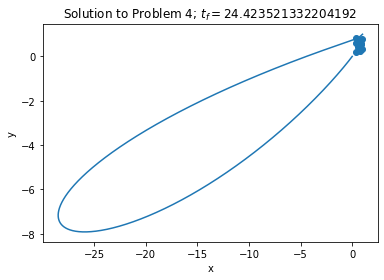

False


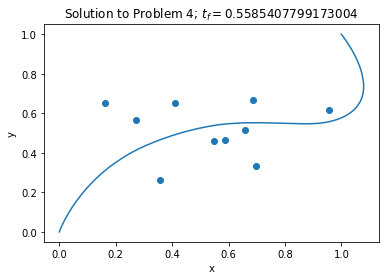

True


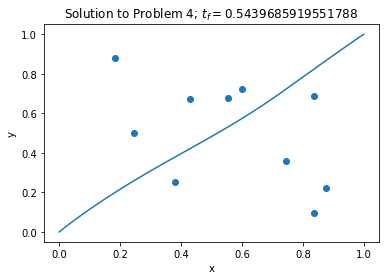

False


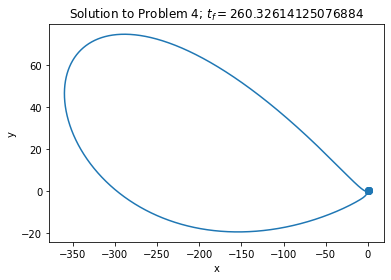

True


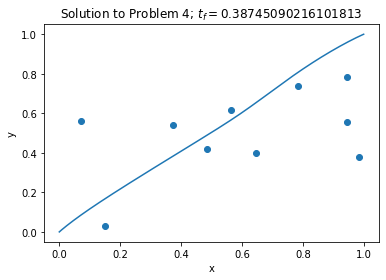

True


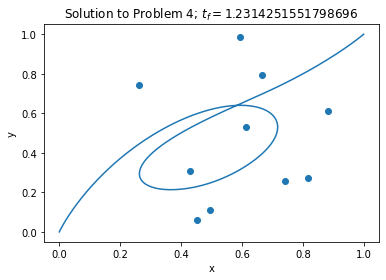

True


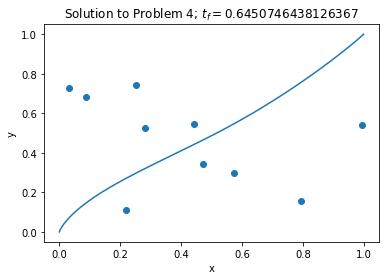

True


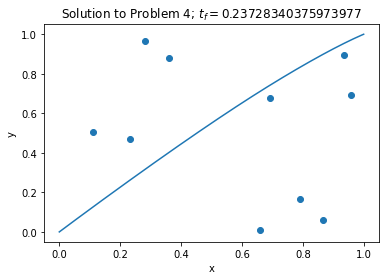

False


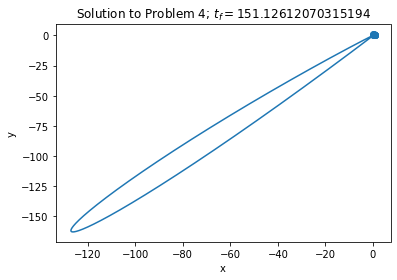

True


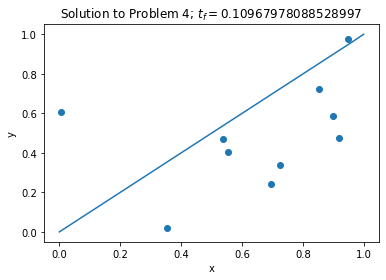

In [14]:
def find_best_path_n_tests(start, end, num_obstacles = 10, N=10):
    '''
    Find the optimal path and time for the free time horizon problem.
    Plot the solution and return the optimal time.
    '''
    if isinstance(num_obstacles, int):
        obstacles = np.random.uniform(start,end,(num_obstacles,2))
    #print(obstacles)    
    k_a, k_c = 0.1,0.5    
    
    def hamiltonian(Y):
        x,y,vx,vy,p1,p2,p3,p4 = Y
        denominators = np.sum((obstacles-Y[:2])**2, axis = 1)**2
        return p1*vx + p2*vy + p3**2/(4*k_a) + p4**2/(4*k_a)\
                - 1 - k_c*np.sum(1/denominators)    
    
    def ode(t,Y,t_f):
        ''' define the ode system '''
        #print(Y)
        px,py,vx,vy,p1,p2,p3,p4 = Y        
        dx = vx
        dy = vy
        dvx = p3/(2*k_a)
        dvy = p4/(2*k_a)        
        denominators = np.sum((obstacles[:,:,np.newaxis]-Y[:2])**2, axis = 1)**2
        dp1 = 2*k_c*np.sum((obstacles[:,0,np.newaxis]-Y[0])/denominators, axis = 0)
        dp2 = 2*k_c*np.sum((obstacles[:,1,np.newaxis]-Y[1])/denominators, axis = 0)
        dp3 = -p1
        dp4 = -p2        
        return t_f[0]*np.array([dx,dy,dvx,dvy,dp1,dp2,dp3,dp4])    
    
    def bc(ya,yb,t_f):
        ''' define the boundary conditions '''
        # ya are the initial values
        # yb are the final values
        # each entry of the return array will be set to zero
        left = np.array([ya[0]-start[0],ya[1]-start[1],ya[2],ya[3]])
        right = np.array([yb[0]-end[0],yb[1]-end[1],yb[2],yb[3]])
        h_tf = np.array([hamiltonian(yb)])
        return np.concatenate((left, right, h_tf))    # Solve the problem N times.
   

    for i in range(N):
        # give the time domain
        t_steps = 100
        t = np.linspace(0,1,t_steps)        # give an initial guess
        y0 = np.zeros((8,t_steps))        #start with an initial straight path
        #TODO: fix to make work with different start and end conditions
        y0[0], y0[1] = t, t
        y0[2:4] = 1
        y0 += np.random.normal(size=(y0.shape))/100000        
        t_f = np.array([1])        # solve the system
        sol = solve_bvp(ode, bc, t, y0, t_f, max_nodes = 30000)        # plot solution
        print(sol.success)
        plt.plot(sol.y[0],sol.y[1])
        plt.scatter(obstacles[:,0],obstacles[:,1])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        obstacles = np.random.uniform(start,end,(num_obstacles,2))
        
find_best_path_n_tests((0,0),(1,1))